### CLIP Load Model 

In [1]:
# (Run once if needed)
# !pip -q install transformers==4.44.2 accelerate timm sentencepiece pillow matplotlib
# !pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # for CUDA envs

import torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests, textwrap
from pathlib import Path

from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to(device).eval()
clip_proc  = CLIPProcessor.from_pretrained(clip_model_id)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### CLIP Download And Load Image

Downloaded 10 images → images_clip_blip2


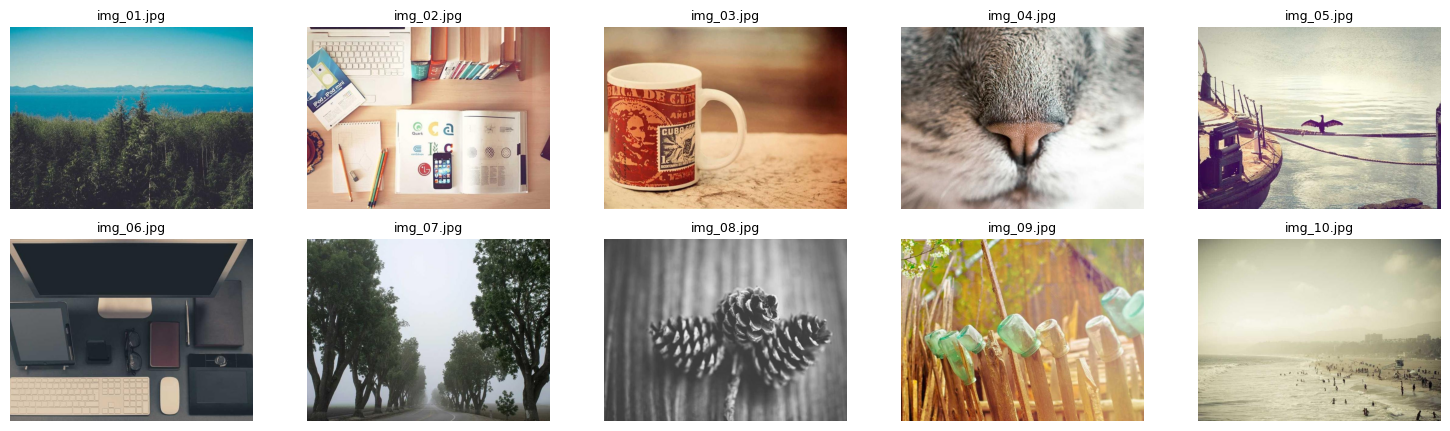

In [2]:
# Use 10 stable Picsum images (800x600)
IMAGE_URLS = [f"https://picsum.photos/id/{i}/800/600" for i in [10,20,30,40,50,60,70,80,90,100]]

SAVE_DIR = Path("images_clip_blip2")
SAVE_DIR.mkdir(exist_ok=True)

def load_image_from_url(url: str) -> Image.Image:
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

downloaded_paths = []
for idx, url in enumerate(IMAGE_URLS, 1):
    img = load_image_from_url(url)
    out = SAVE_DIR / f"img_{idx:02d}.jpg"
    img.save(out, "JPEG", quality=92)
    downloaded_paths.append(str(out))

print(f"Downloaded {len(downloaded_paths)} images → {SAVE_DIR}")

# Build a list of PIL images for later CLIP processing
images = [Image.open(p).convert("RGB") for p in downloaded_paths]

# Quick visual check: contact sheet
cols = 5
rows = int(np.ceil(len(downloaded_paths)/cols))
plt.figure(figsize=(cols*3, rows*2.2))
for i, p in enumerate(downloaded_paths, 1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(Image.open(p))
    ax.axis("off")
    ax.set_title(Path(p).name, fontsize=9)
plt.tight_layout()
plt.show()


###  CLIP Text Prompts And Similarity Computation 

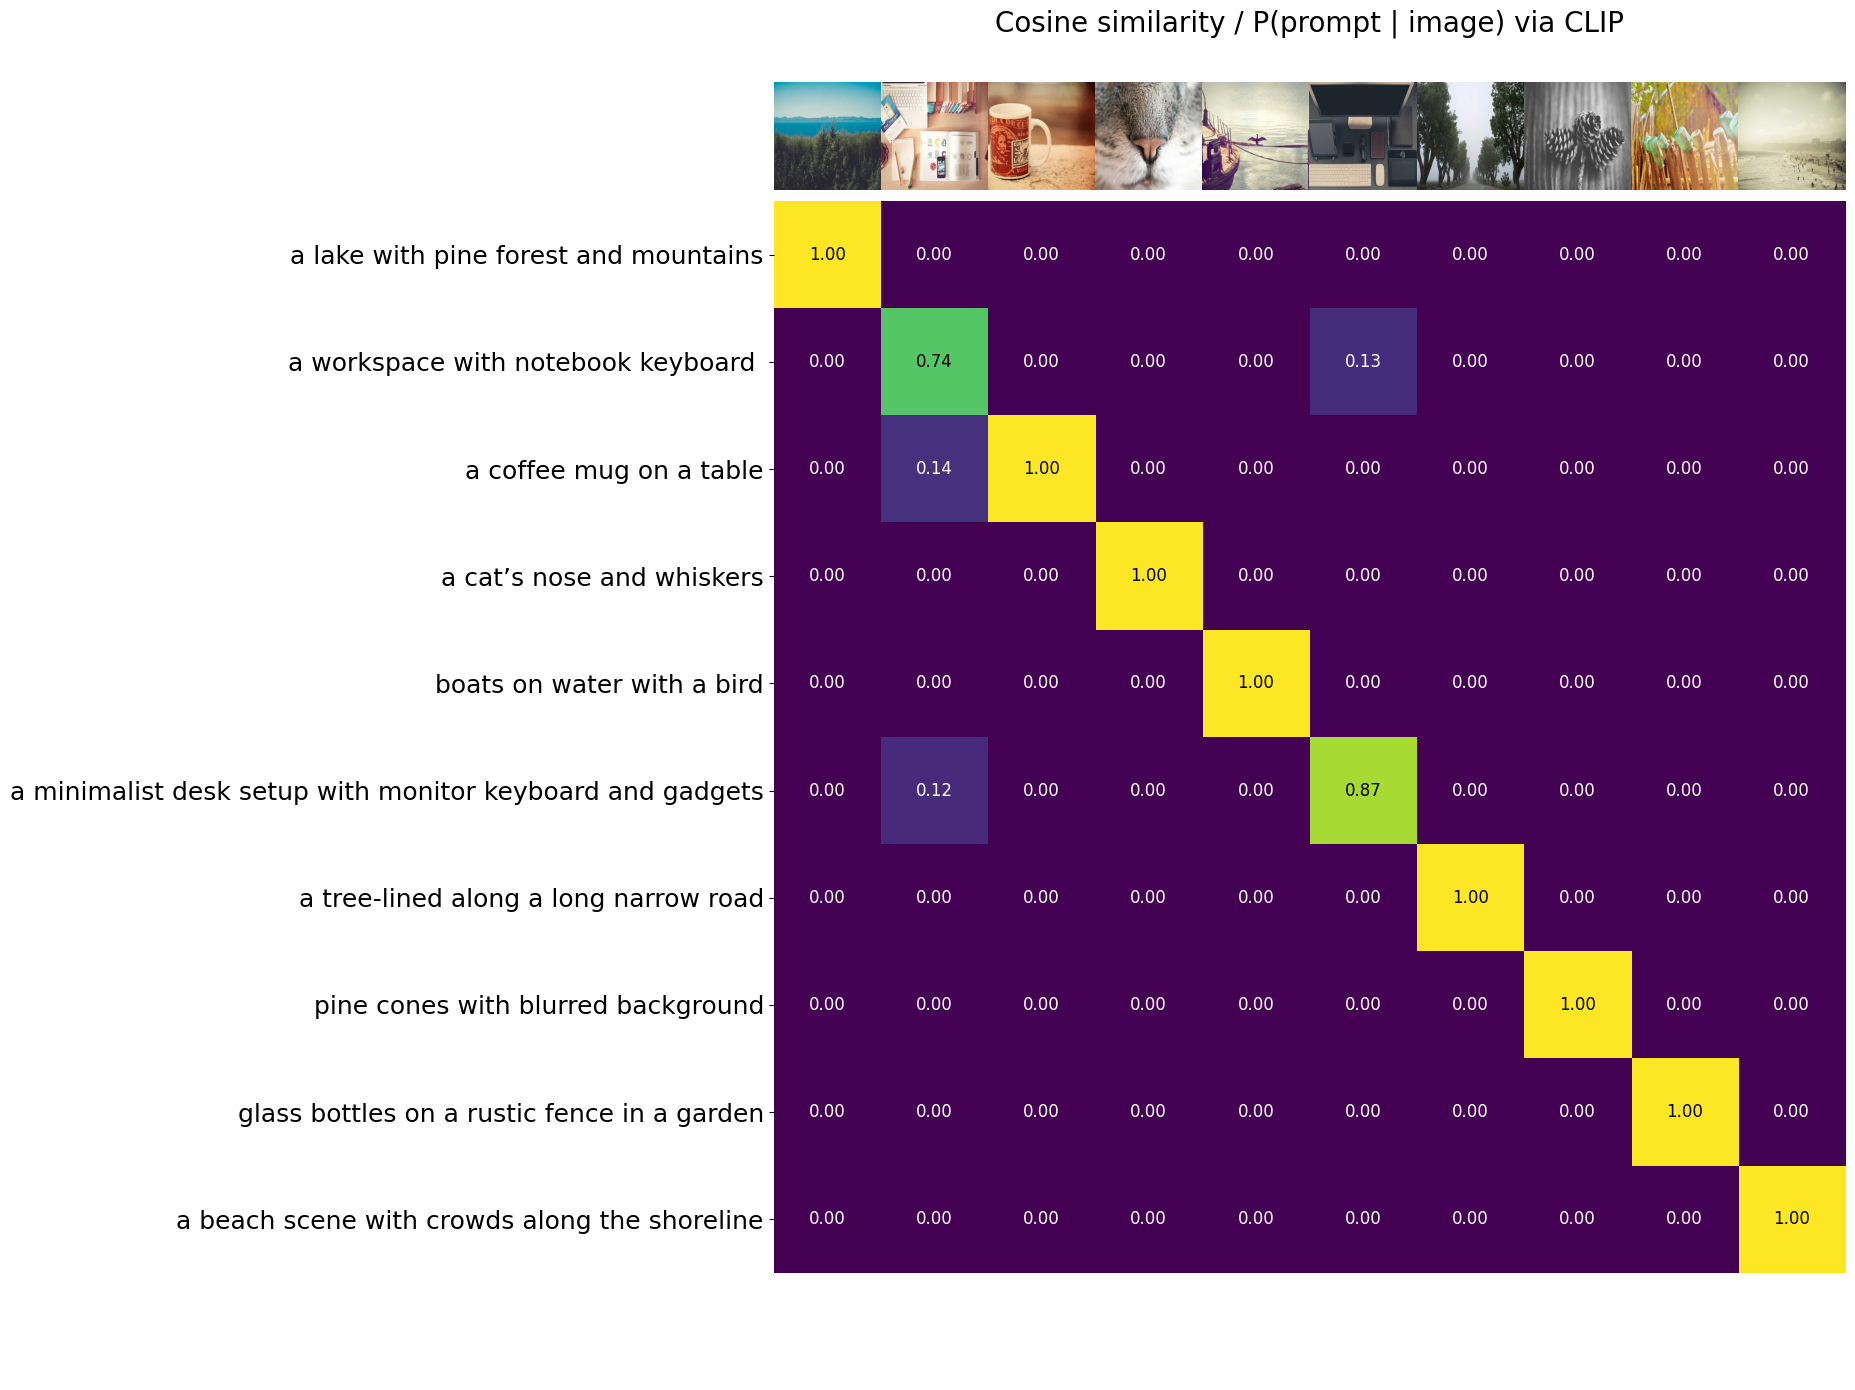

In [3]:
# --- Define text prompts ---  
text_prompts = [
    "a lake with pine forest and mountains",                                        # img_01.jpg
    "a workspace with notebook keyboard ",                                          # img_02.jpg
    "a coffee mug on a table",                                                    # img_03.jpg
    "a cat’s nose and whiskers",                                                    # img_04.jpg
    "boats on water with a bird",                                                  # img_05.jpg
    "a minimalist desk setup with monitor keyboard and gadgets",                   # img_06.jpg
    "a tree-lined along a long narrow road",                                    # img_07.jpg
    "pine cones with blurred background",                                          # img_08.jpg
    "glass bottles on a rustic fence in a garden",                                 # img_09.jpg
    "a beach scene with crowds along the shoreline"                              # img_10.jpg
]

# --- Run CLIP to get logits per image (shape [n_img, n_txt]) ---
with torch.no_grad():
    inputs = clip_proc(text=text_prompts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    logits = outputs.logits_per_image  # [n_img, n_txt]

# Convert to probabilities per image (softmax over prompts), then put prompts on Y
probs = torch.softmax(logits, dim=-1).cpu().numpy()   # [n_img, n_txt]
similarity = probs.T                                   # [n_txt, n_img]  (rows=texts, cols=images)

# --- Aliases to match your plotting variables ---
descriptions = text_prompts
texts = text_prompts
original_images = images

# --- Your plotting style with prompts on Y and thumbnails on top ---
count = len(descriptions)

plt.figure(figsize=(20, 14))
# If you prefer your fixed color scale, keep vmin/vmax. Otherwise, remove them.
plt.imshow(similarity, vmin=0.0, vmax=1.0, cmap="viridis")

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])

# add thumbnails across the top strip
for i, img in enumerate(original_images):
    plt.imshow(img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# numeric probabilities in each cell
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12,
                 color="white" if similarity[y, x] < 0.6 else "black")

# clean frame
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
plt.title("Cosine similarity / P(prompt | image) via CLIP", size=20)
plt.tight_layout()
plt.show()


### CLIP Results Visualization

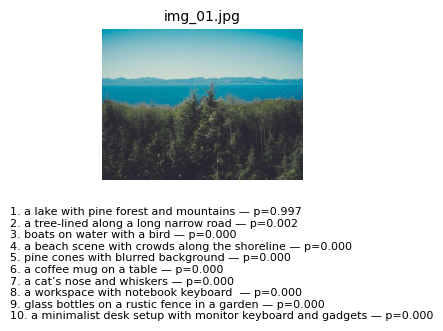

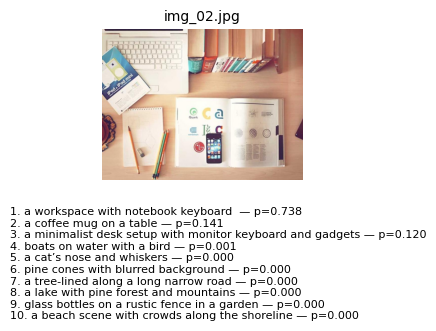

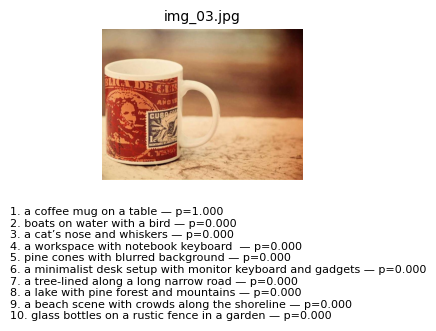

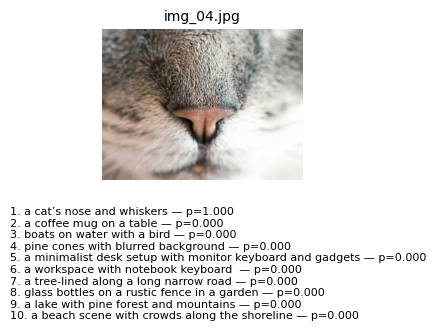

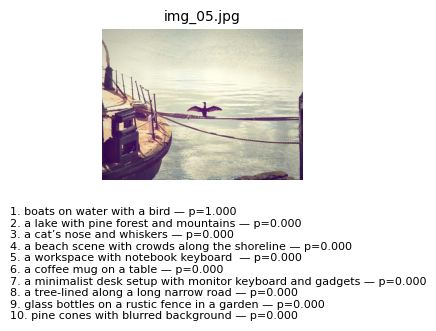

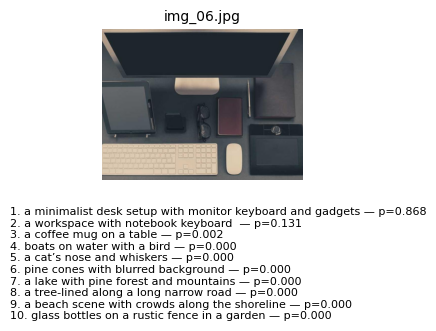

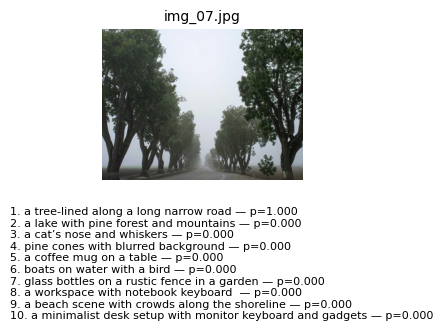

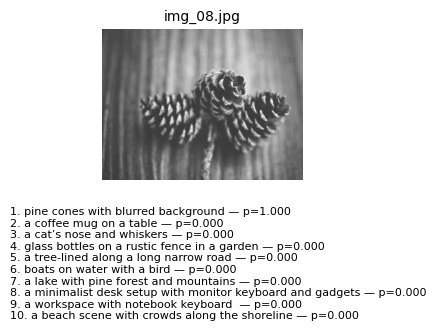

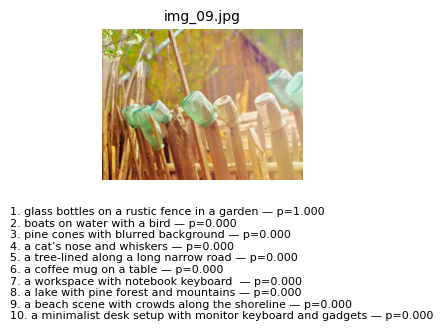

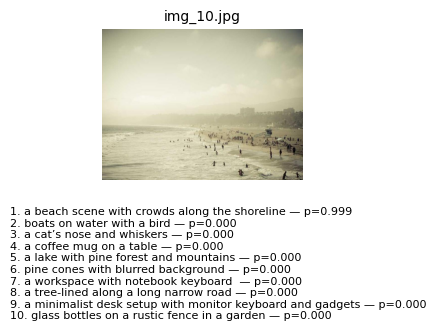

In [4]:
# --- your helper (unchanged) ---
def show_clip_results(path, ranked, k=3):
    img = Image.open(path).convert("RGB")
    plt.figure(figsize=(4,2))
    plt.imshow(img); plt.axis("off")
    topk = ranked[:k]
    lines = [f"{i+1}. {txt} — p={prob:.3f}" for i,(txt,prob) in enumerate(topk)]
    plt.title(Path(path).name, fontsize=10)
    # place text under the image; adjust y if it clips in your environment
    plt.figtext(0.02, -0.06, "\n".join(lines), fontsize=8, ha="left", va="top")
    plt.tight_layout()
    plt.show()

# --- build all_clip_results ---
all_clip_results = []

# If you have file paths (from your Picsum downloader)
paths = downloaded_paths  # or: paths = ["/path/to/img1.jpg", ...]
for p in paths:
    img = Image.open(p).convert("RGB")
    with torch.no_grad():
        inputs = clip_proc(text=text_prompts, images=img, return_tensors="pt", padding=True).to(device)
        out = clip_model(**inputs)
        # probs over prompts for this single image
        probs = torch.softmax(out.logits_per_image, dim=-1).squeeze(0).cpu().numpy()
    ranked = sorted(zip(text_prompts, probs), key=lambda x: x[1], reverse=True)
    all_clip_results.append({"path": p, "ranked": ranked})

# --- display top-k for each image ---
for r in all_clip_results:
    show_clip_results(r["path"], r["ranked"], k=10)



 ### BLIP-2 Load Model 

In [5]:
# BLIP-2 is large; GPU highly recommended.
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import warnings; warnings.filterwarnings("ignore")

blip2_id = "Salesforce/blip2-flan-t5-xl"

blip2_proc  = Blip2Processor.from_pretrained(blip2_id)
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    blip2_id,
    torch_dtype=torch.float16 if device.type=="cuda" else torch.float32
).to(device).eval()

print("BLIP-2 ready on", device)


Some kwargs in processor config are unused and will not have any effect: num_query_tokens. 
Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]


BLIP-2 ready on cuda


### BLIP-2 Download And Load Image 

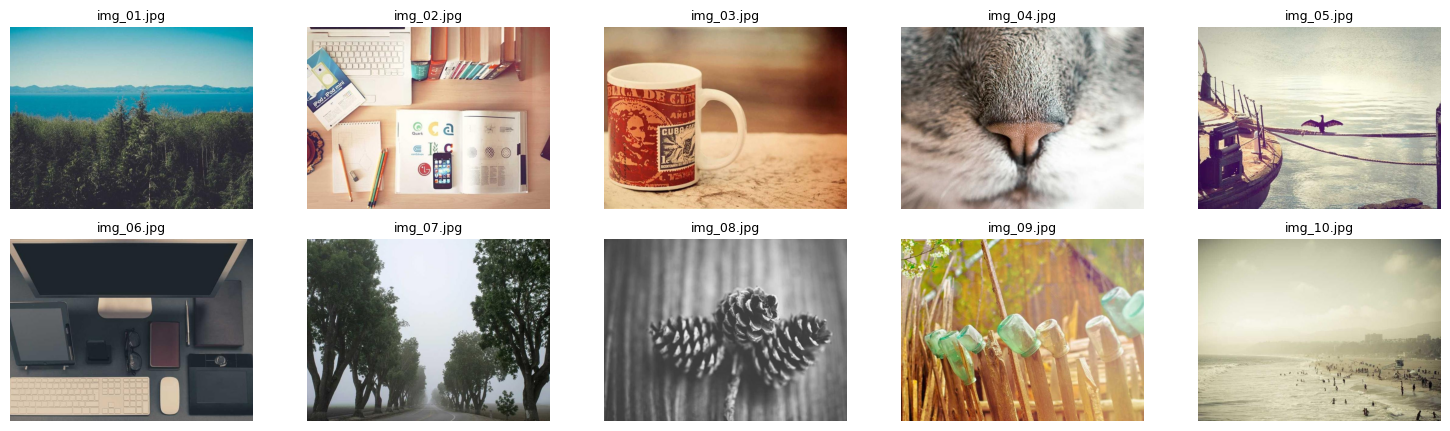

In [6]:
# Reuse the same 10 images downloaded earlier; show another contact sheet for this section
n = len(downloaded_paths)
cols = 5
rows = int(np.ceil(n/cols))
plt.figure(figsize=(cols*3, rows*2.2))
for i, pth in enumerate(downloaded_paths, 1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(Image.open(pth)); ax.axis("off"); ax.set_title(Path(pth).name, fontsize=9)
plt.tight_layout(); plt.show()


### BLIP-2 Generate Captions And VQA

In [7]:
def blip2_generate_caption(img: Image.Image, prompt: str = "Provide a concise caption:"):
    with torch.no_grad():
        inputs = blip2_proc(images=img, text=prompt, return_tensors="pt").to(device, dtype=blip2_model.dtype)
        out_ids = blip2_model.generate(**inputs, max_new_tokens=40)
        return blip2_proc.decode(out_ids[0], skip_special_tokens=True)

def blip2_answer(img: Image.Image, question: str):
    with torch.no_grad():
        inputs = blip2_proc(images=img, text=question, return_tensors="pt").to(device, dtype=blip2_model.dtype)
        out_ids = blip2_model.generate(**inputs, max_new_tokens=30)
        return blip2_proc.decode(out_ids[0], skip_special_tokens=True)

questions = [
    "What main object is in the image?",
    "Is the scene indoors or outdoors?",
]

all_blip2 = []
for pth in downloaded_paths:
    img = Image.open(pth).convert("RGB")
    cap = blip2_generate_caption(img)
    qa  = [(q, blip2_answer(img, q)) for q in questions]
    all_blip2.append({"path": pth, "caption": cap, "qa": qa})

# Print clearly for grading
for d in all_blip2:
    print(Path(d["path"]).name)
    print("  Caption:", d["caption"])
    for q,a in d["qa"]:
        print("  Q:", q)
        print("  A:", a)
    print("-"*60)


img_01.jpg
  Caption: a view of the ocean from a forest
  Q: What main object is in the image?
  A: the ocean
  Q: Is the scene indoors or outdoors?
  A: outdoor
------------------------------------------------------------
img_02.jpg
  Caption: logo design for a startup
  Q: What main object is in the image?
  A: a laptop
  Q: Is the scene indoors or outdoors?
  A: indoors
------------------------------------------------------------
img_03.jpg
  Caption: cuba mug
  Q: What main object is in the image?
  A: coffee mug
  Q: Is the scene indoors or outdoors?
  A: a coffee mug with a stamp on it
------------------------------------------------------------
img_04.jpg
  Caption: a cat's nose
  Q: What main object is in the image?
  A: cat nose
  Q: Is the scene indoors or outdoors?
  A: a close up of a cat's nose
------------------------------------------------------------
img_05.jpg
  Caption: a bird is sitting on a rope in the water
  Q: What main object is in the image?
  A: a bird
  Q: I

## CLIP vs BLIP-2 — Differences, Strengths, Weaknesses

**Differences**
- **CLIP:** ranks how well an image matches your given prompts (retrieval/zero-shot).
- **BLIP-2:** generates free-form captions and answers visual questions (generative).

**Strengths**
- **CLIP:** fast and lightweight; great for label/ranking; easy to add new prompts with no retraining.
- **BLIP-2:** flexible descriptions + VQA; can mention details you didn’t predefine.

**Weaknesses**
- **CLIP:** heavily prompt-dependent; can’t describe beyond the labels you provide.
- **BLIP-2:** heavier/slower (best with GPU); can hallucinate or be vague on small details.
